# IEEE SPS Seasonal School on Networked Federated Learning 
# https://ieeespcasfinland.github.io/
# Exericse 2 

The code snippet below generates a `networkx.graph` object that represents networked data. Each network node $i=0,1,\ldots$ represents a local dataset which consists of $m_{i}$ individual data points. The local datasets   are related by some notion of similarity. The similarity between local datasets at node `i` and node `j` is encoded in an edge weight $A_{ij}$. 

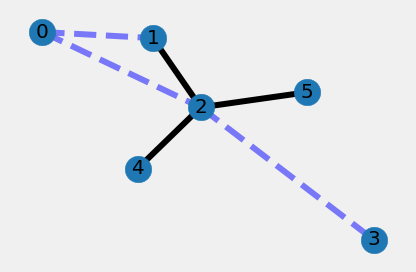

In [119]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()

# add egdes (i,j) along with a weight A_ij 
# note that the function "add_edge" automatically adds nodes 
# to the graph object if this node is not already added 

G.add_edge(0, 1, weight=0.6)
G.add_edge(0, 2, weight=0.2)
G.add_edge(1, 2, weight=0.6)
G.add_edge(2, 3, weight=0.1)
G.add_edge(2, 4, weight=0.7)
G.add_edge(2, 5, weight=0.9)
G.add_edge(0, 1, weight=0.3)

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)

# labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [120]:
print(G.nodes)

[0, 1, 2, 3, 4, 5]


## Network Averaging 

The code snippet below adds the node attribute $y^{(i)}$ to each node $i=0,\ldots,m-1$ of the graph `G` generated in the code snippet above. We denote the attribute value of node `i` as `y[i]`. We then demonstrate how to compute the average $$ (1/m) \sum_{i=0}^{m-1} y[i]$$
of all node values `y[i]` using network averaging. 

This network averaging algorithm can be implemented as message passing where, during each iteration, each node receives intermediate from its neighbours. Based on the received intermediate results each node perfoms some local computation and sends its results back to its neighbours. These message passing rounds (iterations) are repeated for a sufficient number of times.  

In [121]:
import numpy as np 

samplesize=4
true_w = np.random.randn(2)
    
for node_dmy in G.nodes: 
   G.nodes[node_dmy]["y"] = 0.2*np.random.randn(1)+3

In [122]:
for node_dmy in G.nodes: 
    print(G.nodes[node_dmy]["y"])

for edge_dmy in G.edges: 
    print(G.edges[edge_dmy]["weight"])
    
nrnodes = len(G.nodes)
W_MH = np.zeros((nrnodes,nrnodes)) 

# loop over all edges in G.edges ()  

for edge in G.edges(): 
    # store first node of this edge in variable "node_a"
    node_a = edge[0]
    # store second node of this edge in variable "node_b"
    node_b = edge[1]
    # set entry W_MH[node_a,node_b] and W_MH[node_b,node_a] to MH weight  
    W_MH[node_a,node_b] = 1/(np.max([G.degree(node_a),G.degree(node_b)])+1)
    W_MH[node_b,node_a] = 1/(np.max([G.degree(node_a),G.degree(node_b)])+1)

# loop over all nodes in the contact network G
for nodedmy in G.nodes(): 
    # set weights W[nodedmy,nodedmy] to 1 - sum of weights for all neighbors of nodedmy
    W_MH[nodedmy,nodedmy] = 1-np.sum(W_MH[nodedmy,:])

[2.78000609]
[2.99583458]
[2.9463867]
[3.2107713]
[3.00300803]
[3.53580052]
0.3
0.2
0.6
0.1
0.7
0.9


In [123]:
# loop over iterations for computing average 
nriters = 5

for iterdmy in range(nriters):
    # read in current values of "Rate" attributes into numpy array `graphsigold`
    graphsigold = np.fromiter(nx.get_node_attributes(G,'y').values(),dtype=float, count=nrnodes)
    
    # loop over all nodes in "G", use loop variable "node_i"
    for node_i in G.nodes(data=False):
        # set auxiliary variable "tmp" to 0 
        dmy = 0 
        # loop over all neighbours of current node "node_i"
        for node_j in G[node_i]: 
             dmy = dmy+W_MH[node_i,node_j]*graphsigold[node_j]#/(fac1*fac2)
        G.node[node_i]['val'] =W_MH[node_i,node_i]*graphsigold[node_i] + dmy

In [124]:
for node_i in G.nodes(data=True): 
    print(node_i)

(0, {'y': array([2.78000609]), 'val': 2.8796790246852364})
(1, {'y': array([2.99583458]), 'val': 2.9156504395215412})
(2, {'y': array([2.9463867]), 'val': 3.0786345385960048})
(3, {'y': array([3.2107713]), 'val': 3.166707202996907})
(4, {'y': array([3.00300803]), 'val': 2.9935711396492692})
(5, {'y': array([3.53580052]), 'val': 3.4375648861270696})


## A First Federated Learning Algorithm 

The code snippet above demonstrated how to compute the average of a networked dataset that consists of a single number that is assigned to each node. Let us now consider a more interesting network dataset where each node `i` carries a local dataset that consists of several data points. The $r$-th data point assigned to node `i` is characterized by a numeric feature vector $\mathbf{x}^{(i,r)} \in \mathbb{R}^{n}$ and a numeric label value $y^{(i,r)}$. We collect the feature vectors and label values into the feature matrix 
$$\mathbf{X}^{(i)} = \big(\mathbf{x}^{(i,1)},\ldots,\mathbf{x}^{(i,m_{i})} \big)^{T} \mbox{ , and } \mathbf{y}^{(i)} = \big(\mathbf{y}^{(i,1)},\ldots,\mathbf{y}^{(i,m_{i})} \big)^{T}.$$

In [125]:
import numpy as np 

samplesize=10
true_w = np.random.randn(2)
    
for iter_node in G.nodes: 
# create a feature matrix whose rows contain the feature vectors of individual data points 
# each data point is characterized by a feature vector (x1,x2) of lenght 2. The first feature 
# x1 is an arbitrary number while the second feature x2 is fixed to be always equal to 1 (a "dummy feature")
   X = np.hstack((np.random.randn(samplesize,1),np.ones((samplesize,1))))
# create a "ground-truth" weight vector for synthetically generating labels of data points 
# create synthetic labels of data points and store them as the entries of the numpy array y 
   y = X.dot(true_w) + np.random.randn(samplesize,)
    
   # the node attribute "X" stores the feature vectors of the data points associated with a node 
   G.nodes[iter_node]["X"] = X 

   # the node attribute "y" stores the labels for the data points of associated with a node 
   G.nodes[iter_node]["y"] = y 
   
   # the node attribute "weights" stores the weight vector of a linear hypothesis 
   # note that each node might have a potentially different weight vector (personalized model!)  
   G.nodes[iter_node]["weights"] = np.zeros(X.shape[1]) 

Assume that we want to learn a linear predictor $h(\mathbf{x}) = \mathbf{w}^{T} \mathbf{x}$ for the label of a data point based on its features $\mathbf{x}$. During Exercise 1, we have discussed a simple algorithm for computing a choice for the weight vector $\mathbf{w}$. This algorithm was based on repeating the basic gradient descent stop 
\begin{align} 
\mathbf{w}^{(k+1)} & = \mathbf{w}^{(k)} + \alpha \mathbf{X}^{T} \big( \mathbf{y} - \mathbf{X} \mathbf{w}\big) \quad \quad \mbox{ (LinRegGD)}. 
\end{align}
Here, the feature matrix $\mathbf{X}$ and label vector $\mathbf{y}$ is obtained by stacking the node-wise feature matrices $\mathbf{X}^{(i)}$ and label vectors $\mathbf{y}^{(i)}$ as 
$$\mathbf{X} = \big( \big(\mathbf{X}^{(0)} \big)^{T},\ldots, \big(\mathbf{X}^{(m-1)} \big)^{T}\big)^{T}, \mathbf{y}=\big(\big(\mathbf{y}^{(0)} \big)^{T},\ldots, \big(\mathbf{y}^{(m-1)} \big)^{T} \big)^{T}.$$ 

We can rewrite the GD step (LinRegGD) using node-wise feature matrices and label vectors as 
\begin{align} 
\mathbf{w}^{(k+1)} & = \mathbf{w}^{(k)} + \alpha \sum_{i=0}^{m-1} \big( \mathbf{X}^{(i)} \big)^{T} \big( \mathbf{y}^{(i)} - \mathbf{X}^{(i)} \mathbf{w}\big) \quad \quad . 
\end{align}
By defining the "local gradients" $g^{(i)}(\mathbf{w}) := -\big( \mathbf{X}^{(i)} \big)^{T} \big( \mathbf{y}^{(i)} - \mathbf{X}^{(i)} \mathbf{w}\big)$, we obtain 
\begin{align} 
\mathbf{w}^{(k+1)} & = \mathbf{w}^{(k)} - \alpha m  (1/m) \sum_{i=0}^{m-1} g^{(i)}\big( \mathbf{w}^{(k)}\big) \quad \quad \mbox{ (LinRegGDDistr)}. 
\end{align}


In [126]:
logging_gradient =[]
learning_rate = 1/(2*samplesize)
current_weights= np.zeros(true_w.shape)

ITER_AVG = 100 # number of iterations used for computing averages
ITER_GD  = 300 # number of GD steps. each GD step involves ITER_AVG iterations of network averaging


for iter_GD in range(ITER_GD):

# the following "for loop" computes the local gradient at each node 

    for iter_node in G.nodes(data=False): 
        X = G.nodes[iter_node]["X"] 
        y = G.nodes[iter_node]["y"]
        # compute local gradient for current weight vector at node iter_node
        G.nodes[iter_node]["g"] =  -X.transpose().dot(y - X.dot(G.node[iter_node]["weights"]))
    
    # the following code repeats a network averaging step for sufficient repetitions
    # after a sufficient number of iterations of network averaging, the attribte "g" at each node 
    # is an approximation of the average of local gradients 
    for iter_averaging in range(ITER_AVG):
    
    # read in current values of "g" into numpy array `graphsigold`
        curr_locgradients = np.array(list(nx.get_node_attributes(G,"g").values()))
    
    # loop over all nodes in "G", use loop variable "node_i"
        for node_i in G.nodes(data=False):
            # set auxiliary variable "tmp" to 0 
            dmy = np.zeros(2)
            # loop over all neighbours of current node "node_i"
            for node_j in G[node_i]: 
                 dmy = dmy+W_MH[node_i,node_j]*curr_locgradients[node_j,:]
                
            G.node[node_i]["g"] =W_MH[node_i,node_i]*curr_locgradients[node_i,:] + dmy

     # the following loop over all nodes, implements a separate GD step for the weight vector at 
     # each node 
    for iter_node in G.nodes(data=False):
        G.node[iter_node]["weights"] = G.node[iter_node]["weights"] - (learning_rate * G.node[iter_node]["g"] )
        
print(true_w)
print(nx.get_node_attributes(G,"weights").values())
# update the current weight vector via the GD step 

# append the norm of the gradient obtained in this iteration to the list "logging_gradient"
#logging_gradient.append(np.linalg.norm(gradient))

[ 0.22823368 -0.43766639]
dict_values([array([ 0.26252839, -0.44211129]), array([ 0.26252839, -0.44211129]), array([ 0.26252829, -0.44211132]), array([ 0.26252806, -0.44211098]), array([ 0.26252839, -0.44211202]), array([ 0.26252823, -0.44211101])])


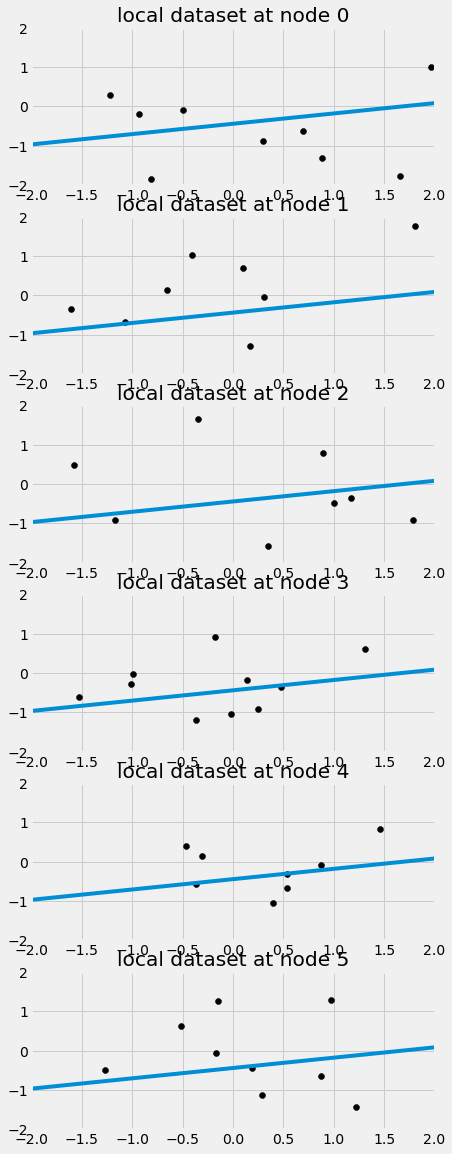

In [133]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(G.nodes),figsize=(7,17))
plt.style.use('fivethirtyeight')
    
X_grid = np.hstack((np.linspace(-2.0, 2.0, 100).reshape(-1,1),np.ones((100,1))))

for iter_node in G.nodes: 
    X = G.nodes[iter_node]["X"]
    y = G.nodes[iter_node]["y"]
    learnt_weights = G.nodes[iter_node]["weights"]
    txt="local dataset at node "+str(iter_node)
    axs[iter_node].set_ylim([-2, 2])
    axs[iter_node].set_xlim([-2, 2])
    axs[iter_node].title.set_text(txt)
    axs[iter_node].scatter(X[:,0], y, color='black')
    # illustrate the learnt weights by a straight line obtained by evaluating the 
    # corresponding linear predictor for a regular grid of feature values X_grid
    axs[iter_node].plot(X_grid[:,0], X_grid.dot(learnt_weights))

plt.subplots_adjust(left=0.1,
                    bottom=0.0, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.2)
plt.show()
# the following code snipet creates 

#plt.

#plt.gca().set_title("Gradient Descent Linear Regressor")